# UMAP clustering for the methylation signature Position Weight Matrices

In [ ]:
import pandas as pd
import numpy as np
import os 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
from sklearn.metrics import silhouette_score
import seaborn as sns
import os
from PIL import Image, ImageFont
from sklearn.cluster import KMeans

seed = 98
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_HAMBI/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv'
df = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(df.shape)

## FILTERING
### Removing the contigs that have no methyaltions (or under 20) detected for all of the three types. These are the rows where all values in the columns are 0s
#### All data 💠

In [ ]:
# remove rows where df.iloc[:, :-17] meaning no methylation detected or less than 20 detected since those are converted to 0 filled matrices
df = df.loc[(df.iloc[:, :-17] != 0).any(axis=1)]

In [ ]:
print(df.shape[0])

In [ ]:
df['Domain to species'].value_counts()

In [ ]:
df['Domain to species'].nunique(dropna = False)

In [ ]:
df['Domain to genus'].nunique(dropna = False)

In [ ]:
df['Domain to family'].nunique(dropna = False)

In [ ]:
df['Domain to order'].nunique(dropna = False)

In [ ]:
df['Domain to class'].nunique(dropna = False)

In [ ]:
df['Domain to phylum'].nunique(dropna = False)

### Number of contigs where missing the species information
#### All data 💠

In [ ]:
len(df[df['Domain to species'].isna()])

In [ ]:
n_neighbors = [20, 30 ]
min_dist = [0.01, 0.1, 0.2]
colors = sns.color_palette("hls", 32).as_hex()

unique_species = df['Domain to species'].unique()
num_species = len(unique_species)
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#7FFF00", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]
custom_colors = color_dict


for n in n_neighbors:
    for m in min_dist:
        
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df.iloc[:, :-17])
        UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df['Domain to species'],
            'Domain to genus': df['Domain to genus'],
            'element': df['element']
        })
        # clustering
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df['cluster'] = k_labels
        UMAP_df['Domain to species'] = UMAP_df['Domain to species'].fillna('NA')
        column = 'Domain to species'
        value_counts = UMAP_df[column].value_counts().to_dict()

        UMAP_df[f'{column}_with_counts'] = UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df['count'] = UMAP_df[column].map(value_counts)
        UMAP_df = UMAP_df.sort_values(by=['count'], ascending=False)

        UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df[f'{column}_with_counts'],
            categories=UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1500,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}.png')
        #fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}.html')

### Using the best n_neighbours and min_dist to get clear clusters
#### All data 💠

In [ ]:
n_neighbors = [30]
min_dist = [0.1]
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df.iloc[:, :-17])
        UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df['Domain to species'],
            'Domain to genus': df['Domain to genus'],
            'element': df['element']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        UMAP_df['Domain to species'] = UMAP_df['Domain to species'].fillna('NA')

        value_counts = UMAP_df[column].value_counts().to_dict()

        UMAP_df[f'{column}_with_counts'] = UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df['count'] = UMAP_df[column].map(value_counts)
        UMAP_df = UMAP_df.sort_values(by=['count'], ascending=False)

        UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df[f'{column}_with_counts'],
            categories=UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}.png')
        fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}.html')


In [ ]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
                 '#bcbd22', '#17becf', '#ff8da1']

# Convert 'kmeans' to a categorical variable with explicit order from 0 to 10
UMAP_df = UMAP_df.sort_values(by=['cluster'], ascending=True)
UMAP_df['clusters'] = pd.Categorical(UMAP_df['cluster'].astype(int), categories=range(0, 11), ordered=True)


# Plot UMAP with the kmeans clusters
fig = px.scatter(UMAP_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    labels={f'{column}_with_counts': column},
                    color='clusters', 
                    title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                    color_discrete_sequence=custom_colors,
                    hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m} with kmeans clusters'

# Update the layout of the figure
fig.update_layout(
    height=1300,
    width=1200,
    title_text=title,
    showlegend=True,
    legend=dict(
        x=0.5,
        y=-0.1,
        traceorder="normal",
        xanchor='center',
        yanchor='top',
        orientation='h'
    ),
    template='simple_white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,  
        linecolor='black', 
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,
        linecolor='black',
        linewidth=1,
        mirror=True
    )
)

# Show the figure
fig.show()
fig.write_image(f'UMAP_HAMBI/UMAP_{n}_{m}_kmeans.png')
fig.write_html(f'UMAP_HAMBI/UMAP_{n}_{m}_kmeans.html')


In [ ]:
len(UMAP_df['Domain to species'].value_counts())

In [ ]:
species_cluster_count = UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

In [ ]:
# Pivot the table to make species as rows and clusters as columns
species_cluster_counts = UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

# Pivot the table to make species as rows and clusters as columns
species_cluster_pivot = species_cluster_counts.pivot(index='Domain to species', columns='cluster', values='Count').fillna(0)

# Convert all columns to numeric to ensure proper summation
species_cluster_pivot = species_cluster_pivot.apply(pd.to_numeric)

# Calculate the row sum (total contigs per species) and add it as a new column
species_cluster_pivot['SUM'] = species_cluster_pivot.sum(axis=1)
species_cluster_pivot.sort_values(by='SUM', ascending=False, inplace =True)
species_cluster_pivot

### Save to file
#### All data 💠

In [ ]:
species_cluster_pivot.to_csv('UMAP_HAMBI/HAMBI_species_cluster_pivot.csv', index=True)

In [ ]:
def calculate_shannon_entropy(pivot_table):
    cluster_columns = pivot_table.columns[:-1]  
    total_samples = pivot_table['SUM'].sum() 

    total_weighted_entropy = 0

    for cluster in cluster_columns:
        total_in_cluster = pivot_table[cluster].sum()
        
        if total_in_cluster == 0:
            continue  
        
        # the proportion of each species in this cluster
        proportions = pivot_table[cluster] / total_in_cluster
        
        # the entropy for this cluster
        entropy = -np.sum(proportions * np.log2(proportions + 1e-10))  # Small value to avoid log(0)
        
        # Weight the entropy by the proportion of the cluster size relative to the total
        weighted_entropy = (total_in_cluster / total_samples) * entropy
        total_weighted_entropy += weighted_entropy

        print(f"Entropy for cluster {cluster}: {entropy:.4f}")
    
    print(f"Total Weighted Entropy: {total_weighted_entropy:.4f}")
    return total_weighted_entropy

calculate_shannon_entropy(species_cluster_pivot)

### Connecting clusters to taxa
#### All data 💠

In [ ]:
def return_index(cluster:int, df:pd.DataFrame) -> tuple:
    """Returns the index of the cluster in the dataframe
    """
    return df[df['cluster'] == cluster]

In [ ]:
UMAP_df['cluster'].value_counts()

In [ ]:
cluster_data = {}
for cluster in UMAP_df['cluster'].unique():
    cluster_data[cluster] = UMAP_df[UMAP_df['cluster'] == cluster].index.tolist()

In [ ]:
cluster_data.keys()

### Plot the number of each species in each cluster
#### All data 💠

In [ ]:
for cluster in cluster_data.keys():
    # Select the subset of UMAP_df for the current cluster
    cluster_df = UMAP_df.loc[cluster_data[cluster]]
    
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Domain to species', data=cluster_df, order=cluster_df['Domain to species'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Cluster {cluster}')
    plt.show()

### Plot to how many clusters one species has been assigned by the clustering algoritms
#### All data 💠

In [ ]:
species_kmeans_counts = UMAP_df.groupby('Domain to species')['cluster'].nunique()

species_kmeans_counts.plot(kind='bar', color='lightgreen')
plt.title('KMEANS')
plt.xlabel('Species')
plt.ylabel('Number of Unique KMeans Clusters')

plt.xticks(rotation=90)
plt.show()

### Create concatenated images of the sequencing logos for each cluster and species
#### All data 💠

In [ ]:
def search_images_in_subfolders(path_to_folders, index, image_types):
    """Search for images by index and type from subfolders, adding placeholders if necessary."""
    images = {}
    
    subfolders = [f for f in os.listdir(path_to_folders) if os.path.isdir(os.path.join(path_to_folders, f))]
    for img_type in image_types:
        image_found = False
        for subfolder in subfolders:
            image_path = os.path.join(path_to_folders, subfolder, 'logos', f"{index}_{img_type}.png")            
            if os.path.exists(image_path):
                try:
                    images[img_type] = Image.open(image_path)
                    image_found = True
                    break
                except Exception as e:
                    print(f"Failed to open image {image_path}: {e}")
                    images[img_type] = Image.new('RGB', (1200, 300), 'white')
                    image_found = True
                    break
        if not image_found:
            images[img_type] = Image.new('RGB', (1200, 300), 'white')
            print(f"No image found for {img_type}, using placeholder.")
    
    return images

def standardize_image_sizes(images, size=(1200, 300)):
    """Resize all images to a standard size."""
    resized_images = {}
    for key, img in images.items():
        resized_images[key] = img.resize(size)
    return resized_images

def combine_images_horizontally(images):
    """Combine images horizontally."""
    if not images:
        return None
    images = standardize_image_sizes(images)
    
    total_width = sum(img.width for img in images.values())
    max_height = max(img.height for img in images.values())

    new_im = Image.new('RGB', (total_width, max_height), 'white')
    x_offset = 0
    for img_type, img in images.items():
        new_im.paste(img, (x_offset, 0))
        x_offset += img.width
    return new_im

def combine_images_vertically(image_list):
    """Combine images vertically to form a single cluster image."""
    if not image_list or all(img is None for img in image_list):
        return None
    max_width = max(img.width for img in image_list)
    total_height = sum(img.height for img in image_list)
    
    new_im = Image.new('RGB', (max_width, total_height), 'white')
    y_offset = 0
    for img in image_list:
        new_im.paste(img, (0, y_offset))
        y_offset += img.height
    return new_im


def display_and_save_image(image, title, save_path=None):
    """Display an image using matplotlib and optionally save it to a file."""
    if image is None:
        print("No image to display or save.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    if save_path:
        try:
            if image.width == 0 or image.height == 0:
                print(f"Image {title} has invalid dimensions and cannot be saved.")
            else:
                image.save(save_path)
                print(f"Saved image to {save_path}")
        except Exception as e:
            print(f"Failed to save the image {title} at {save_path}: {e}")
    plt.close()

def process_clusters_and_species_images(UMAP_df, path_to_folders, image_types, outputpath):
    """Process images based on K-means clusters and species in the DataFrame."""
    cluster_col = 'cluster'  # Use only the K-means clustering column

    for cluster in UMAP_df[cluster_col].unique():
        print(f"Processing K-means cluster {cluster}")
        cluster_df = UMAP_df[UMAP_df[cluster_col] == cluster]

        for species in cluster_df['Domain to species'].unique():
            print(f"Processing species {species} in K-means cluster {cluster}")
            species_images = []
            indexes = cluster_df[cluster_df['Domain to species'] == species].index

            for index in indexes:
                images = search_images_in_subfolders(path_to_folders, index, image_types)
                combined_horizontal_image = combine_images_horizontally(images)
                if combined_horizontal_image:
                    species_images.append(combined_horizontal_image)

            final_image = combine_images_vertically(species_images)

            if final_image:
                filename = f"kmeans_cluster_{cluster}_{species}.png"
                display_path = os.path.join(outputpath, filename)
                display_and_save_image(final_image, f"K-means Cluster {cluster} - {species}", display_path)
    print("Done")

In [ ]:
path_to_folders = '/scratch/project_2006608/Methylation/HAMBI_data/'
image_types = ['m4C_logo', 'm6A_logo', 'modified_base_logo']
outputpath = '/scratch/project_2006608/Methylation/notebooks/logos_HAMBI/'

process_clusters_and_species_images(UMAP_df, path_to_folders, image_types, outputpath)

In [ ]:
species_kmeans_counts = filt_UMAP_df.groupby('Domain to species')['cluster'].nunique()

species_kmeans_counts.plot(kind='bar', color='lightgreen')
plt.title('KMEANS')
plt.xlabel('Species')
plt.ylabel('Number of Unique KMeans Clusters')

plt.xticks(rotation=90)
plt.show()

## Trying shorter range of the sequence
### Less noise 🔷
#### -10...0...10
#### -5...0...5

In [ ]:
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_HAMBI_short/'

In [ ]:
file_path_10 = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data_short_10.tsv'
df_10 = pd.read_csv(file_path_10, sep='\t', index_col=0, low_memory=False)

In [ ]:
file_path_5 = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data_short_5.tsv'
df_5 = pd.read_csv(file_path_5, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(df_10.shape)

In [ ]:
print(df_5.shape)

## FILTERING
### Removing the contigs that have no methyaltions (or under 20) detected for all of the three types. These are the rows where all values in the columns are 0s
### Less noise 🔷

In [ ]:
# remove rows where df.iloc[:, :-17] meaning no methylation detected or less than 20 detected since those are converted to 0 filled matrices
df_10 = df_10.loc[(df_10.iloc[:, :-17] != 0).any(axis=1)]
df_5 = df_5.loc[(df_5.iloc[:, :-17] != 0).any(axis=1)]

In [ ]:
print(df_10.shape[0])
print(df_5.shape[0])

In [ ]:
df_10['Domain to species'].value_counts()
df_5['Domain to species'].value_counts()

In [ ]:
df_10['Domain to species'].nunique(dropna = False)
df_5['Domain to species'].nunique(dropna = False)

In [ ]:
len(df_10[df_10['Domain to species'].isna()])
len(df_5[df_5['Domain to species'].isna()])

In [ ]:
df_10.head()
df_5.head()

### Draw UMAP
#### Less noise 🔷
#### -10...0...10

In [ ]:
n_neighbors = [20, 30 ]
min_dist = [0.01, 0.1, 0.2]
colors = sns.color_palette("hls", 32).as_hex()

unique_species = df_10['Domain to species'].unique()
num_species = len(unique_species)
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#7FFF00", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]
custom_colors = color_dict


for n in n_neighbors:
    for m in min_dist:
        
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_10.iloc[:, :-17])
        UMAP_df_10  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_10['Domain to species'],
            'Domain to genus': df_10['Domain to genus'],
            'element': df_10['element']
        })
        # clustering
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df_10['cluster'] = k_labels
        UMAP_df_10['Domain to species'] = UMAP_df_10['Domain to species'].fillna('NA')
        column = 'Domain to species'
        value_counts = UMAP_df_10[column].value_counts().to_dict()

        UMAP_df_10[f'{column}_with_counts'] = UMAP_df_10[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_10['count'] = UMAP_df_10[column].map(value_counts)
        UMAP_df_10 = UMAP_df_10.sort_values(by=['count'], ascending=False)

        UMAP_df_10[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_10[f'{column}_with_counts'],
            categories=UMAP_df_10[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df_10, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1500,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI_short/UMAP_{n}_{m}.png')
        #fig.write_html(f'UMAP_HAMBI_short/UMAP_{n}_{m}.html')

### Using the best n_neighbours and min_dist to get clear clusters
#### Less noise 🔷
#### -10...0...10

In [ ]:
n_neighbors = [30]
min_dist = [0.2]
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_10.iloc[:, :-17])
        UMAP_df_10  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': UMAP_df_10['Domain to species'],
            'Domain to genus': UMAP_df_10['Domain to genus'],
            'element': UMAP_df_10['element']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df_10['cluster'] = k_labels
        
        column = 'Domain to species'
        UMAP_df_10['Domain to species'] = UMAP_df_10['Domain to species'].fillna('NA')

        value_counts = UMAP_df_10[column].value_counts().to_dict()

        UMAP_df_10[f'{column}_with_counts'] = UMAP_df_10[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_10['count'] = UMAP_df_10[column].map(value_counts)
        UMAP_df_10 = UMAP_df_10.sort_values(by=['count'], ascending=False)

        UMAP_df_10[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_10[f'{column}_with_counts'],
            categories=UMAP_df_10[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df_10, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI_short/UMAP_{n}_{m}_short_10.png')
        fig.write_html(f'UMAP_HAMBI_short/UMAP_{n}_{m}_short_10.html')


### Draw UMAP
#### Less noise 🔷
#### -5...0...5

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



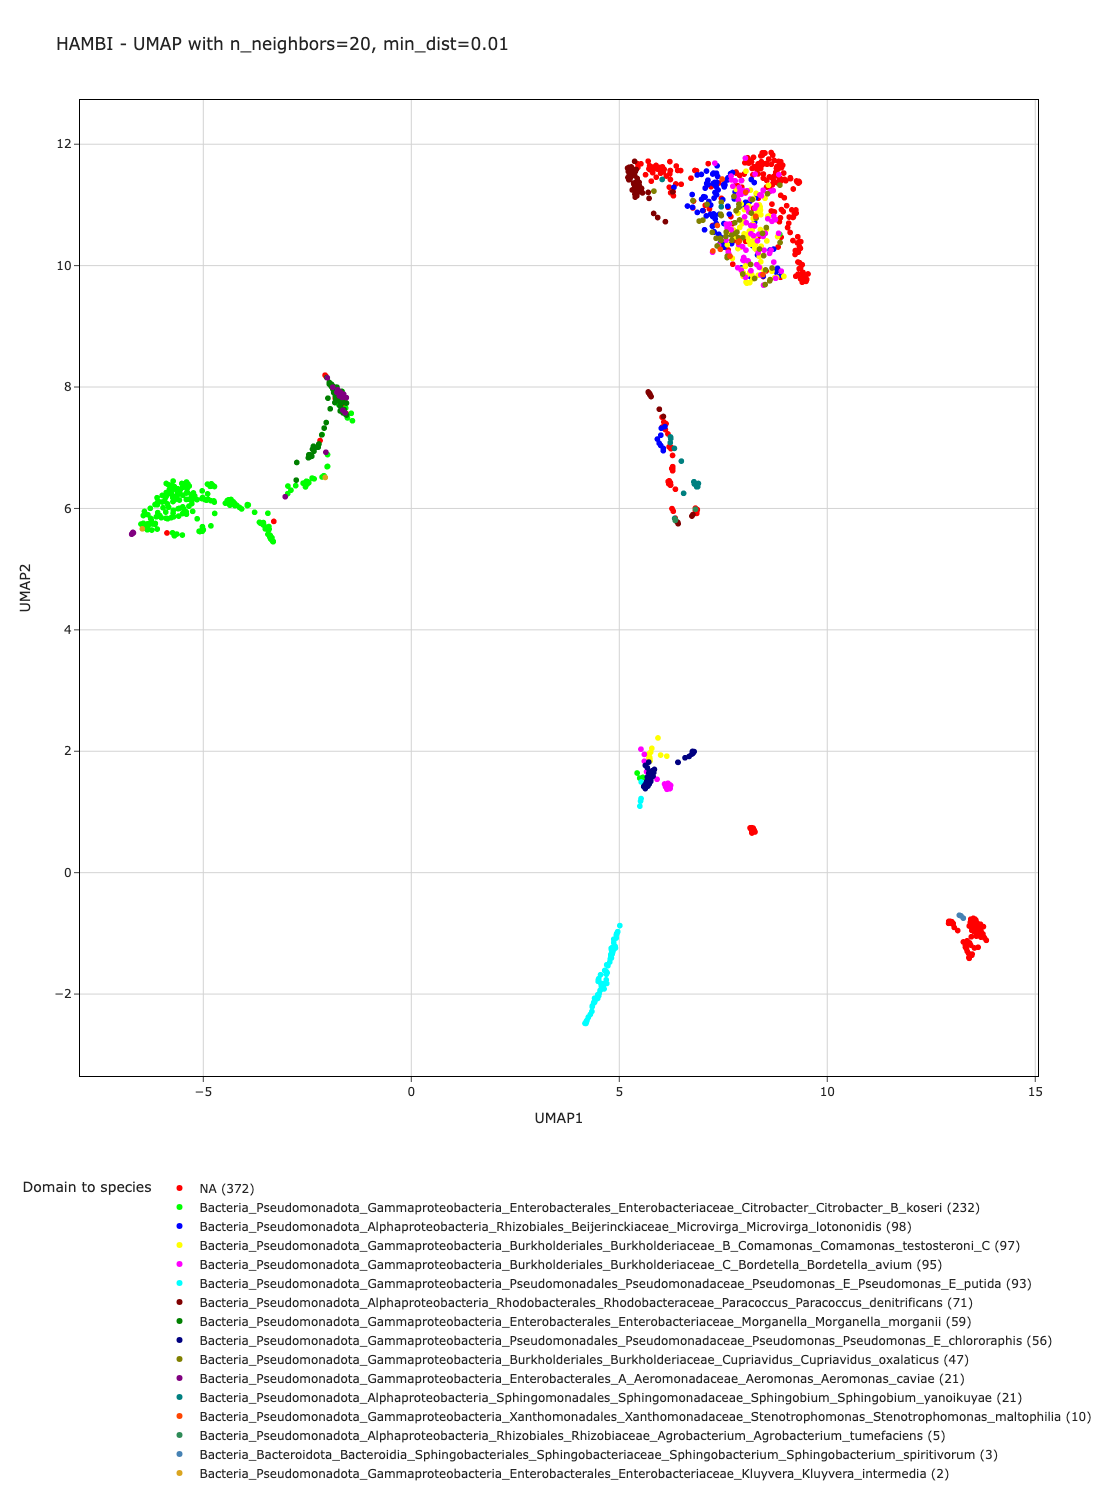

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



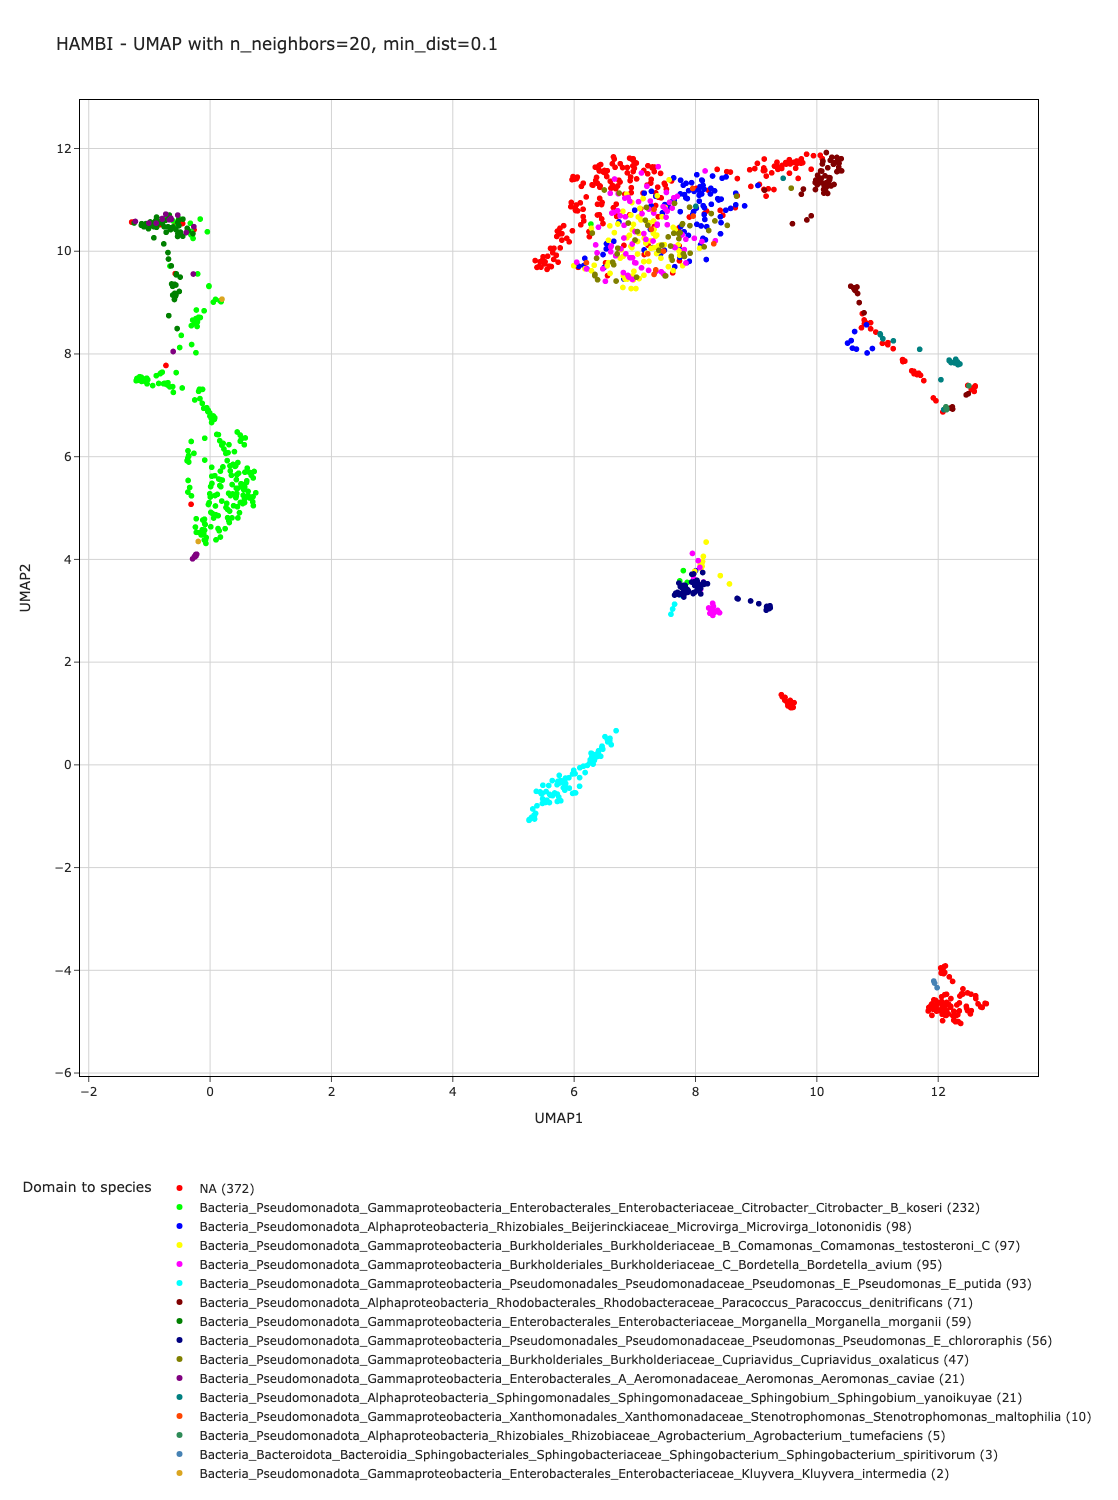

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



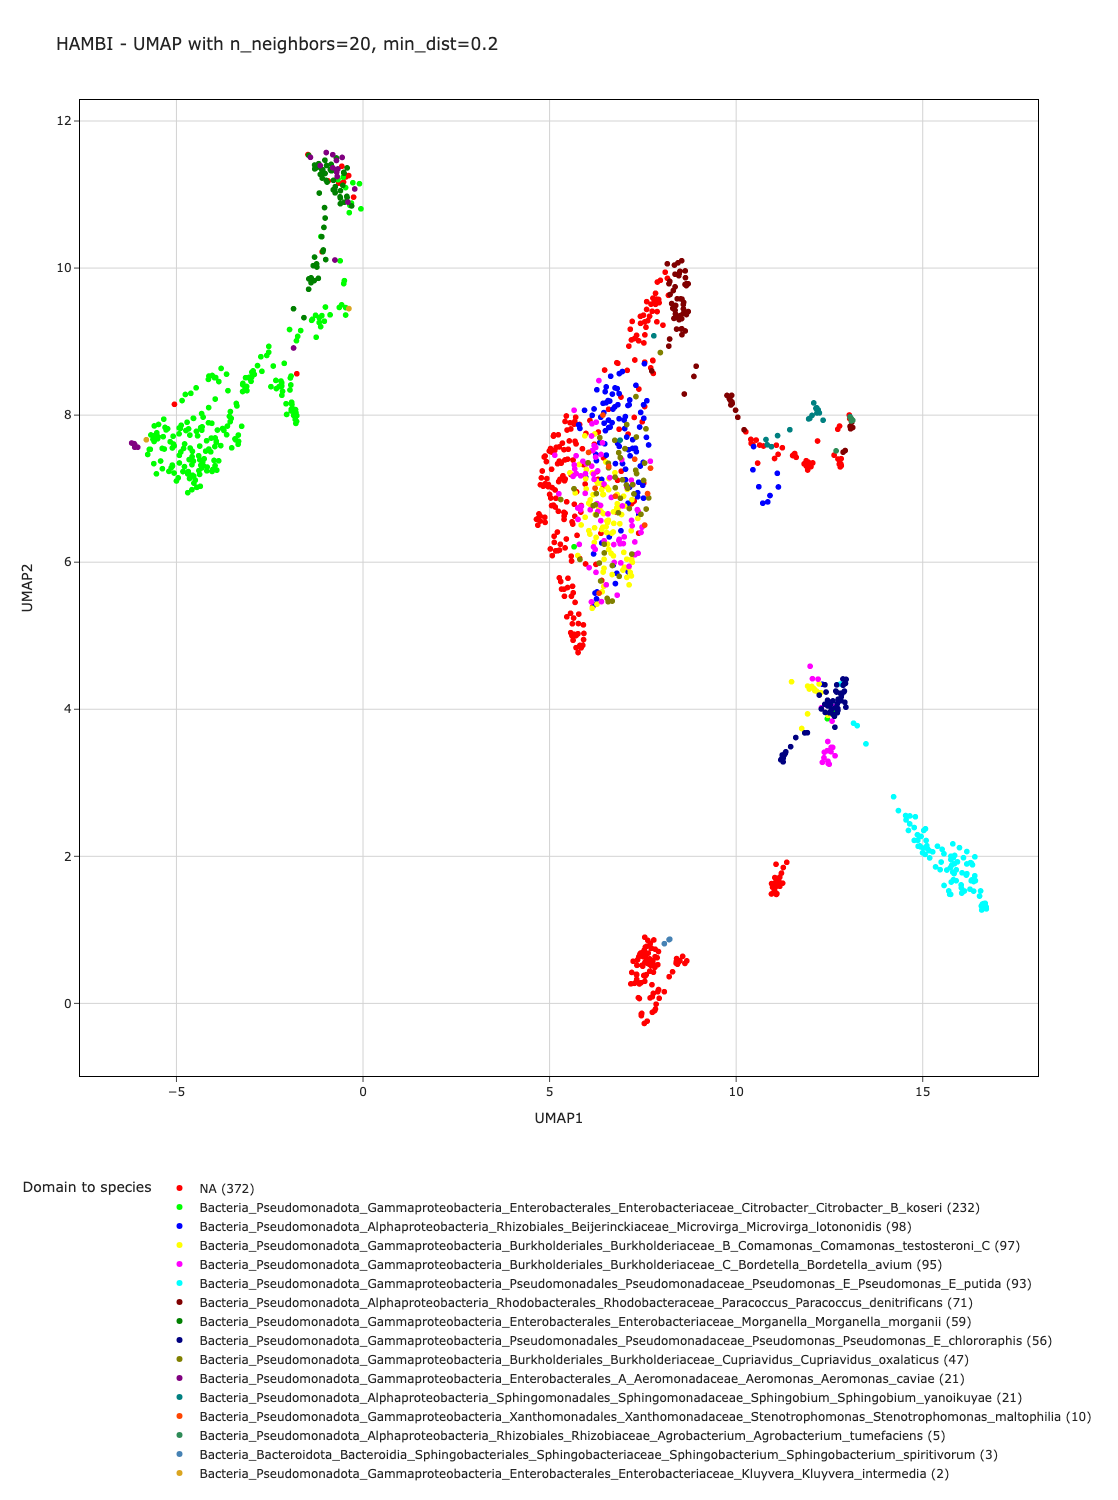

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



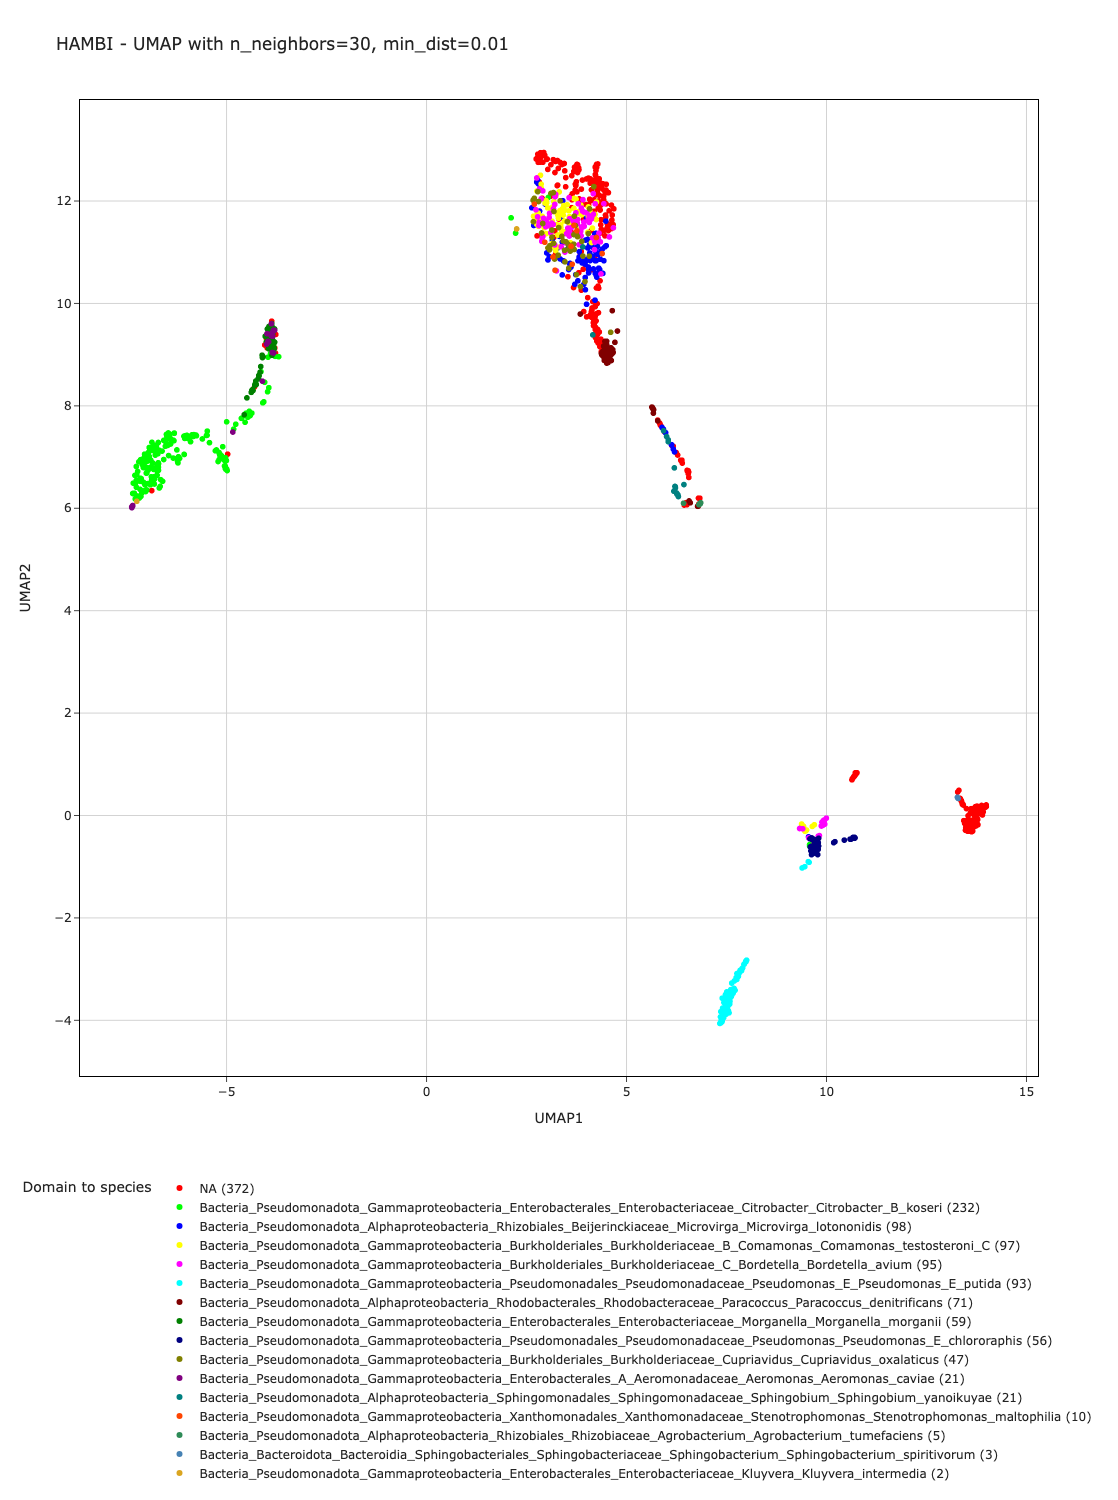

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



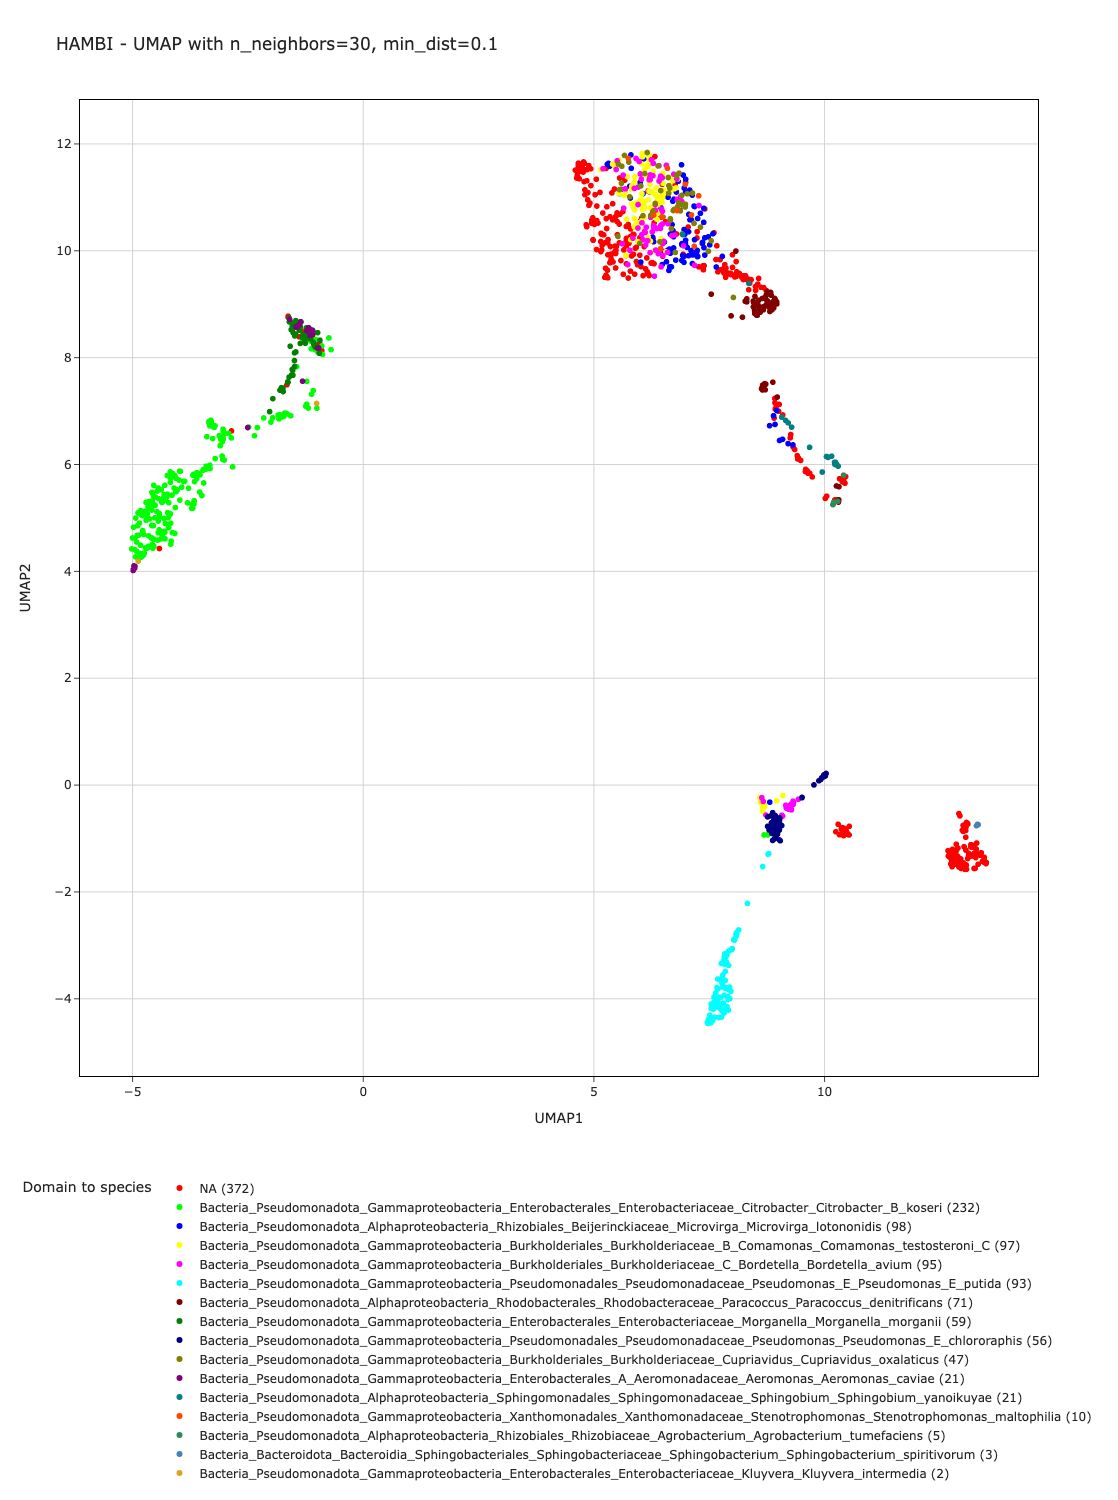

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



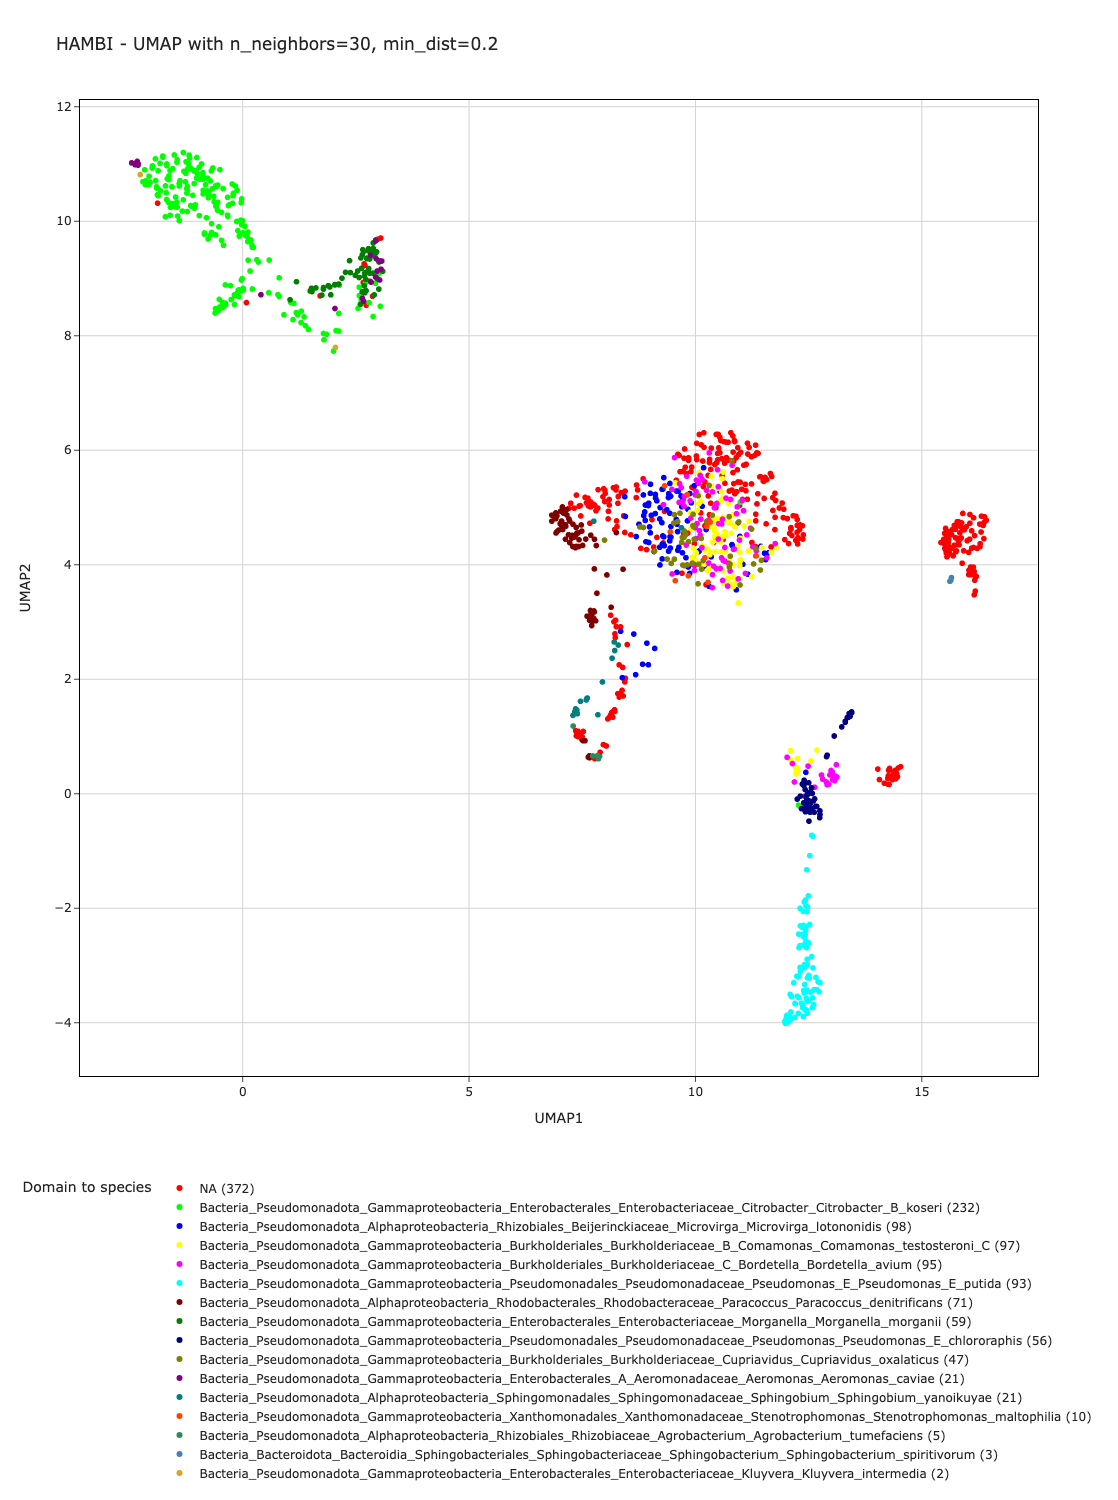

In [80]:
n_neighbors = [20, 30 ]
min_dist = [0.01, 0.1, 0.2]
colors = sns.color_palette("hls", 32).as_hex()

unique_species = df_5['Domain to species'].unique()
num_species = len(unique_species)
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#7FFF00", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]
custom_colors = color_dict


for n in n_neighbors:
    for m in min_dist:
        
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_5.iloc[:, :-17])
        UMAP_df_5  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_5['Domain to species'],
            'Domain to genus': df_5['Domain to genus'],
            'element': df_5['element']
        })
        # clustering
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df_5['cluster'] = k_labels
        UMAP_df_5['Domain to species'] = UMAP_df_5['Domain to species'].fillna('NA')
        column = 'Domain to species'
        value_counts = UMAP_df_5[column].value_counts().to_dict()

        UMAP_df_5[f'{column}_with_counts'] = UMAP_df_5[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_5['count'] = UMAP_df_5[column].map(value_counts)
        UMAP_df_5 = UMAP_df_5.sort_values(by=['count'], ascending=False)

        UMAP_df_5[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_5[f'{column}_with_counts'],
            categories=UMAP_df_5[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df_5, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1500,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI_short/UMAP_{n}_{m}.png')
        #fig.write_html(f'UMAP_HAMBI_short/UMAP_{n}_{m}.html')

### Using the best n_neighbours and min_dist to get clear clusters
#### Less noise 🔷
#### -5...0...5

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



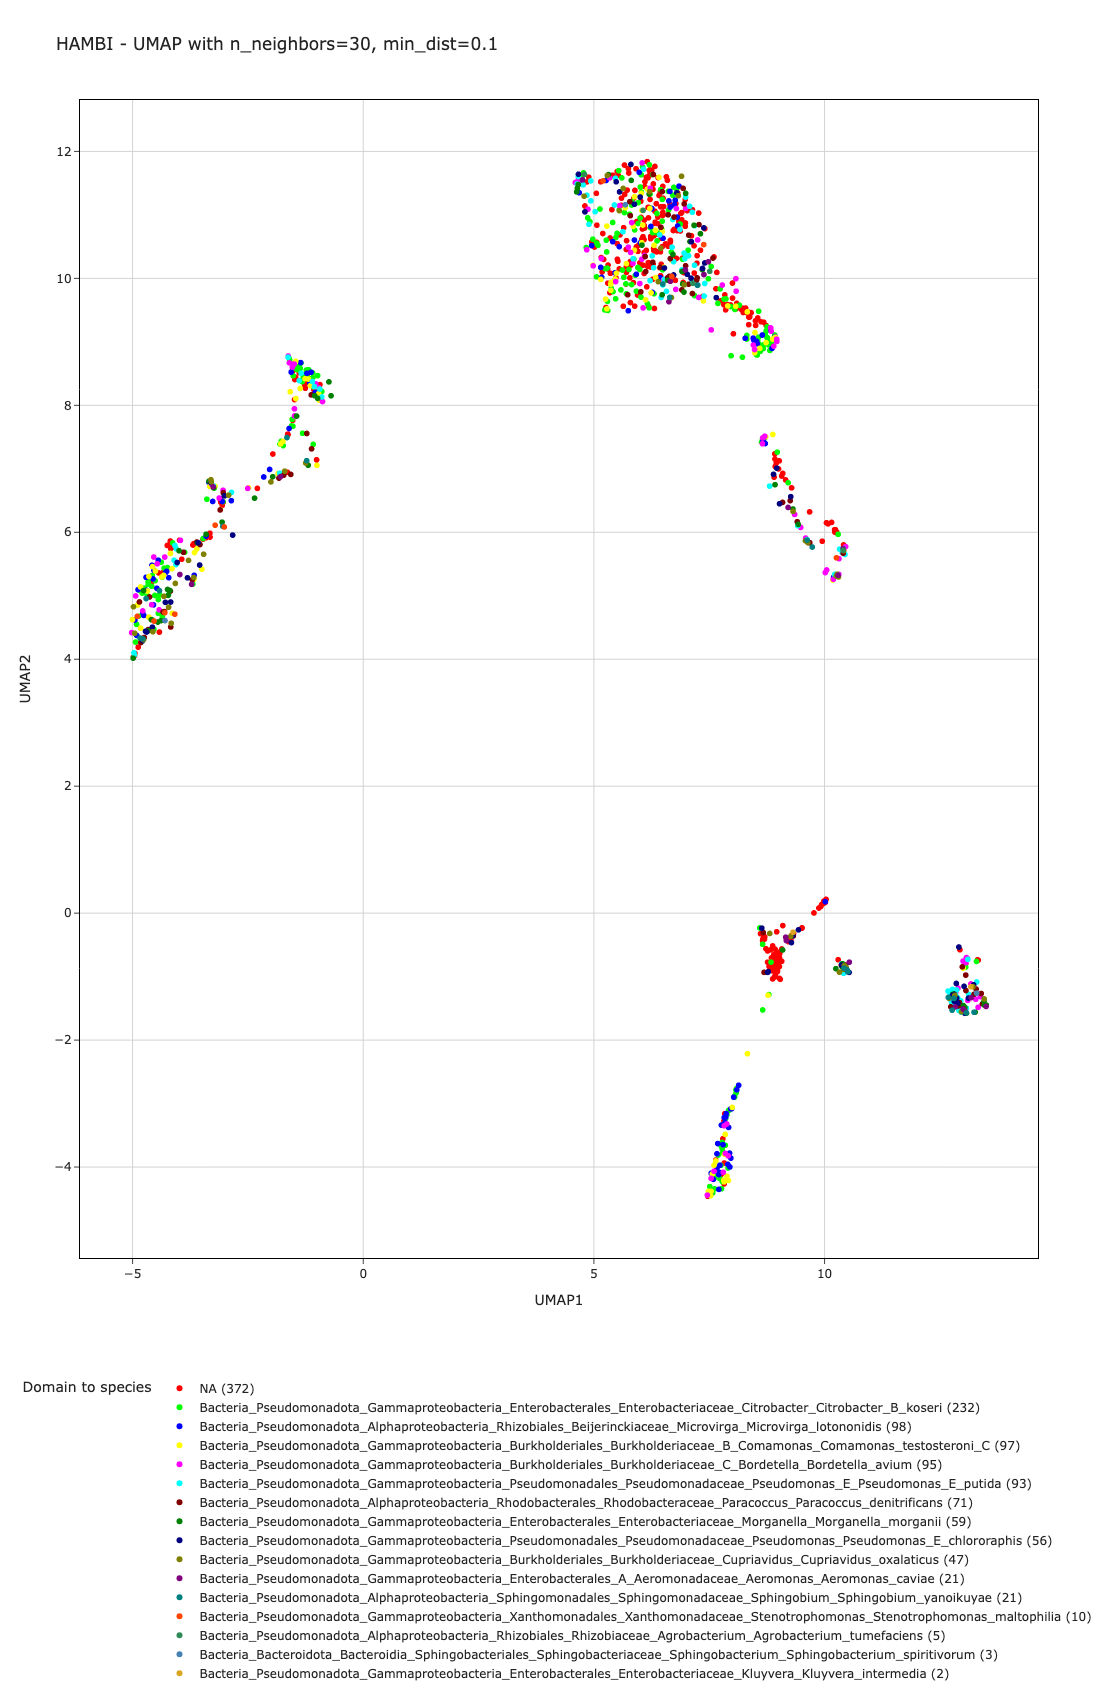

In [81]:
n_neighbors = [30]
min_dist = [0.1]
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_5.iloc[:, :-17])
        UMAP_df_5  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': UMAP_df_5['Domain to species'],
            'Domain to genus': UMAP_df_5['Domain to genus'],
            'element': UMAP_df_5['element']
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        UMAP_df_5['cluster'] = k_labels
        
        column = 'Domain to species'
        UMAP_df_5['Domain to species'] = UMAP_df_5['Domain to species'].fillna('NA')

        value_counts = UMAP_df_5[column].value_counts().to_dict()

        UMAP_df_5[f'{column}_with_counts'] = UMAP_df_5[column].apply(lambda x: f'{x} ({value_counts[x]})')

        UMAP_df_5['count'] = UMAP_df_5[column].map(value_counts)
        UMAP_df_5 = UMAP_df_5.sort_values(by=['count'], ascending=False)

        UMAP_df_5[f'{column}_with_counts'] = pd.Categorical(
            UMAP_df_5[f'{column}_with_counts'],
            categories=UMAP_df_5[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(UMAP_df_5, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI_short/UMAP_{n}_{m}_short_5.png')
        fig.write_html(f'UMAP_HAMBI_short/UMAP_{n}_{m}_short_5.html')


**************************************************************************
### UMAP clustering for the methylation signature Position Weight Matrices
#### Top feature data 🔝

##### Create data set with only top features (150)

In [ ]:
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_HAMBI_top150_features/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv'
df = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(df.shape)

In [ ]:
# Filter based on the features in 'RF_HAMBI/Domain_to_species_top_features.csv'
## Load file
file_path = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_species_top150_features.csv'
feature_list = pd.read_csv(file_path, sep=',')
feature_list.head()

In [ ]:
# Extract identifiers into list
taxa_headers = df.columns[493:510]
column_headers = pd.DataFrame(taxa_headers.tolist(), columns=['Feature'])
print(column_headers.head())

# Append the column_headers to it
feature_list = pd.concat([feature_list, column_headers], ignore_index=True)

print(feature_list)

In [ ]:
# Extract columns
columns_to_keep = feature_list['Feature'].tolist()
df_top150 = df[columns_to_keep]
df_top150.head()

In [ ]:
df_top150['Domain to species'].value_counts(dropna = False)

In [ ]:
row_names = df_top150.index
print(row_names)

In [ ]:
len(df_top150['Domain to species'].value_counts(dropna = False))

## FILTERING
### Removing the contigs that have no methyaltions (or under 20) detected for all of the three types. These are the rows where all values in the columns are 0s
#### Top feature data 🔝

In [ ]:
# remove rows where df.iloc[:, :-17] meaning no methylation detected or less than 20 detected since those are converted to 0 filled matrices
df_top150 = df_top150.loc[(df_top150.iloc[:, :-17] != 0).any(axis=1)]

In [ ]:
print(df_top150.shape[0])

In [ ]:
df_top150['Domain to species'].value_counts(dropna = False)

In [ ]:
df_top150['Domain to species'].nunique(dropna = False)

In [ ]:
df_top150['Domain to genus'].nunique(dropna = False)

In [ ]:
df_top150['Domain to family'].nunique(dropna = False)

In [ ]:
df_top150['Domain to order'].nunique(dropna = False)

In [ ]:
df_top150['Domain to class'].nunique(dropna = False)

In [ ]:
df_top150['Domain to phylum'].nunique(dropna = False)

In [ ]:
len(df_top150[df_top150['Domain to species'].isna()])

In [ ]:
n_neighbors = [20, 30 ]
min_dist = [0.01, 0.1, 0.2]
colors = sns.color_palette("hls", 32).as_hex()

unique_species = df_top150['Domain to species'].unique()
num_species = len(unique_species)
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#7FFF00", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]
custom_colors = color_dict


for n in n_neighbors:
    for m in min_dist:
        
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_top150.iloc[:, :-17])
        top150_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_top150['Domain to species'],
            'Domain to genus': df_top150['Domain to genus'],
            'element': df_top150['element'],
            'contig': df_top150.index,
        })
        # clustering
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        top150_UMAP_df['cluster'] = k_labels
        top150_UMAP_df['Domain to species'] = top150_UMAP_df['Domain to species'].fillna('NA')
        column = 'Domain to species'
        value_counts = top150_UMAP_df[column].value_counts().to_dict()

        top150_UMAP_df[f'{column}_with_counts'] = top150_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        top150_UMAP_df['count'] = top150_UMAP_df[column].map(value_counts)
        top150_UMAP_df = top150_UMAP_df.sort_values(by=['count'], ascending=False)

        top150_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            top150_UMAP_df[f'{column}_with_counts'],
            categories=top150_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(top150_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True, 'contig': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1500,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        #fig.write_image(f'UMAP_HAMBI_top_features/UMAP_{n}_{m}.png')
        #fig.write_html(f'UMAP_HAMBI_top_features/UMAP_{n}_{m}.html')

### Using the best n_neighbours and min_dist to get clear clusters
#### Top feature data 🔝

In [ ]:
n_neighbors = [30]
min_dist = [0.1]
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_top150.iloc[:, :-17])
        top150_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_top150['Domain to species'],
            'Domain to genus': df_top150['Domain to genus'],
            'element': df_top150['element'],
            'contig': df_top150.index,
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        top150_UMAP_df['cluster'] = k_labels
        
        column = 'Domain to species'
        top150_UMAP_df['Domain to species'] = top150_UMAP_df['Domain to species'].fillna('NA')

        value_counts = top150_UMAP_df[column].value_counts().to_dict()

        top150_UMAP_df[f'{column}_with_counts'] = top150_UMAP_df[column].apply(lambda x: f'{x} ({value_counts[x]})')

        top150_UMAP_df['count'] = top150_UMAP_df[column].map(value_counts)
        top150_UMAP_df = top150_UMAP_df.sort_values(by=['count'], ascending=False)

        top150_UMAP_df[f'{column}_with_counts'] = pd.Categorical(
            top150_UMAP_df[f'{column}_with_counts'],
            categories=top150_UMAP_df[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(top150_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True, 'contig': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI_top150_features/UMAP_{n}_{m}.png')
        fig.write_html(f'UMAP_HAMBI_top150_features/UMAP_{n}_{m}.html')


In [ ]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
                 '#bcbd22', '#17becf', '#ff8da1']

# Convert 'kmeans' to a categorical variable with explicit order from 0 to 10
top150_UMAP_df = top150_UMAP_df.sort_values(by=['cluster'], ascending=True)
top150_UMAP_df['clusters'] = pd.Categorical(top150_UMAP_df['cluster'].astype(int), categories=range(0, 11), ordered=True)


# Plot UMAP with the kmeans clusters
fig = px.scatter(top150_UMAP_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    labels={f'{column}_with_counts': column},
                    color='clusters', 
                    title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                    color_discrete_sequence=custom_colors,
                    hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True} )
title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m} with kmeans clusters'

# Update the layout of the figure
fig.update_layout(
    height=1300,
    width=1200,
    title_text=title,
    showlegend=True,
    legend=dict(
        x=0.5,
        y=-0.1,
        traceorder="normal",
        xanchor='center',
        yanchor='top',
        orientation='h'
    ),
    template='simple_white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,  
        linecolor='black', 
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False,
        showline=True,
        linecolor='black',
        linewidth=1,
        mirror=True
    )
)

# Show the figure
fig.show()
fig.write_image(f'UMAP_HAMBI_top150_features/UMAP_{n}_{m}_kmeans.png')
fig.write_html(f'UMAP_HAMBI_top150_features/UMAP_{n}_{m}_kmeans.html')

In [ ]:
species_cluster_count = top150_UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

In [ ]:
# Pivot the table to make species as rows and clusters as columns
species_cluster_counts = top150_UMAP_df.groupby(['Domain to species', 'cluster']).size().reset_index(name='Count')

# Pivot the table to make species as rows and clusters as columns
species_cluster_pivot = species_cluster_counts.pivot(index='Domain to species', columns='cluster', values='Count').fillna(0)

# Convert all columns to numeric to ensure proper summation
species_cluster_pivot = species_cluster_pivot.apply(pd.to_numeric)

# Calculate the row sum (total contigs per species) and add it as a new column
species_cluster_pivot['SUM'] = species_cluster_pivot.sum(axis=1)
species_cluster_pivot.sort_values(by='SUM', ascending=False, inplace =True)
species_cluster_pivot

### Save to file
#### Top feature data 🔝

In [ ]:
species_cluster_pivot.to_csv('UMAP_HAMBI_top150_features/HAMBI_species_cluster_pivot_top150_features.csv', index=True)

In [ ]:
def calculate_shannon_entropy(pivot_table):
    cluster_columns = pivot_table.columns[:-1]  
    total_samples = pivot_table['SUM'].sum() 

    total_weighted_entropy = 0

    for cluster in cluster_columns:
        total_in_cluster = pivot_table[cluster].sum()
        
        if total_in_cluster == 0:
            continue  
        
        # the proportion of each species in this cluster
        proportions = pivot_table[cluster] / total_in_cluster
        
        # the entropy for this cluster
        entropy = -np.sum(proportions * np.log2(proportions + 1e-10))  # Small value to avoid log(0)
        
        # Weight the entropy by the proportion of the cluster size relative to the total
        weighted_entropy = (total_in_cluster / total_samples) * entropy
        total_weighted_entropy += weighted_entropy

        print(f"Entropy for cluster {cluster}: {entropy:.4f}")
    
    print(f"Total Weighted Entropy: {total_weighted_entropy:.4f}")
    return total_weighted_entropy

calculate_shannon_entropy(species_cluster_pivot)

### Connecting clusters to taxa
#### Top feature data 🔝

In [ ]:
def return_index(cluster:int, df:pd.DataFrame) -> tuple:
    """Returns the index of the cluster in the dataframe
    """
    return top150_df[top150_df['cluster'] == cluster]

In [ ]:
top150_UMAP_df['cluster'].value_counts()

In [ ]:
cluster_data = {}
for cluster in top150_UMAP_df['cluster'].unique():
    cluster_data[cluster] = top150_UMAP_df[top150_UMAP_df['cluster'] == cluster].index.tolist()

In [ ]:
cluster_data.keys()

### Plot the number of each species in each cluster
#### Top feature data 🔝

In [ ]:
for cluster in cluster_data.keys():
    # Select the subset of filt_UMAP_df for the current cluster
    cluster_df = top150_UMAP_df.loc[cluster_data[cluster]]
    
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Domain to species', data=cluster_df, order=cluster_df['Domain to species'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Cluster {cluster}')
    plt.show()

### Plot to how many clusters one species has been assigned by the clustering algoritms
#### Top feature data

In [ ]:
species_kmeans_counts = top150_UMAP_df.groupby('Domain to species')['cluster'].nunique()

species_kmeans_counts.plot(kind='bar', color='lightgreen')
plt.title('KMEANS')
plt.xlabel('Species')
plt.ylabel('Number of Unique KMeans Clusters')

plt.xticks(rotation=90)
plt.show()

### Extract clusters and redraw UMAP with subset of data
#### Top feature data 🔝 (70)
##### Cluster1: *Pseudomonas_E putida*

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C1 = top70_UMAP_df.loc[(top70_UMAP_df['UMAP1']>= 10) & (top70_UMAP_df['UMAP1']<= 15)
    & (top70_UMAP_df['UMAP2']>= -2) & (top70_UMAP_df['UMAP2']<= 0)]

# Check
top70_UMAP_df_C1.head()

# Save those contig IDs to extract from the 'df_top70'
top70_UMAP_df_C1.index.to_list()

df_top70_C1 = df_top70[df_top70.index.isin(top70_UMAP_df_C1.index)]
print(top70_UMAP_df_C1)

In [ ]:
# Save contig IDs
top70_C1_contigs = df_top70_C1.index.to_list()

directory = 'UMAP_HAMBI_top_features'
file_path = os.path.join(directory, 'top70_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters and redraw UMAP with subset of data
#### Top feature data 🔝 (70)
##### Cluster1A: *Pseudomonas_E putida*

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C1A = top70_UMAP_df.loc[(top70_UMAP_df['UMAP1']>= 12) & (top70_UMAP_df['UMAP1']<= 12.71)
    & (top150_UMAP_df['UMAP2']>= -0.8510) & (top70_UMAP_df['UMAP2']<= -0.6000)]

# Check
top70_UMAP_df_C1A.head()

# Save those contig IDs to extract from the 'df_top150'
top70_UMAP_df_C1A.index.to_list()

df_top70_C1A = df_top70[top70_UMAP_df.index.isin(top150_UMAP_df_C1A.index)]
print(top70_UMAP_df_C1A)

In [ ]:
# Save contig IDs
top70_C1A_contigs = df_top70_C1A.index.to_list()

directory = 'UMAP_HAMBI_top70_features'
file_path = os.path.join(directory, 'top70_C1A_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C1A_contigs:
        file.write(f"{item}\n")

### Extract clusters and redraw UMAP with subset of data
#### Top feature data 🔝 (70)
##### Cluster1B: *Pseudomonas_E putida*

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C1B = top70_UMAP_df.loc[(top70_UMAP_df['UMAP1']>= 12.5) & (top70_UMAP_df['UMAP1']<= 13)
    & (top70_UMAP_df['UMAP2']>= -1.53) & (top70_UMAP_df['UMAP2']<= -1.12)]

# Check
top70_UMAP_df_C1B.head()

# Save those contig IDs to extract from the 'df_top150'
top70_UMAP_df_C1B.index.to_list()

df_top70_C1B = df_top70[df_top70.index.isin(top70_UMAP_df_C1B.index)]
print(top70_UMAP_df_C1B)

In [ ]:
# Save contig IDs
top70_C1B_contigs = df_top70_C1B.index.to_list()

directory = 'UMAP_HAMBI_top70_features'
file_path = os.path.join(directory, 'top70_C1B_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C1B_contigs:
        file.write(f"{item}\n")

### Extract clusters and redraw UMAP with subset of data
#### Top feature data 🔝 (70)
##### Cluster1C: *Pseudomonas_E putida*

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C1C = top70_UMAP_df.loc[(top150_UMAP_df['UMAP1']>= 12.9) & (top70_UMAP_df['UMAP1']<= 13.31)
    & (top70_UMAP_df['UMAP2']>= -1.124) & (top70_UMAP_df['UMAP2']<= -0.534)]

# Check
top70_UMAP_df_C1C.head()

# Save those contig IDs to extract from the 'df_top150'
top70_UMAP_df_C1C.index.to_list()

df_top70_C1C = df_top70[df_top70.index.isin(top70_UMAP_df_C1C.index)]
print(top70_UMAP_df_C1C)

In [ ]:
# Save contig IDs
top70_C1C_contigs = df_top70_C1C.index.to_list()

directory = 'UMAP_HAMBI_top70_features'
file_path = os.path.join(directory, 'top70_C1C_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C1C_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### Top feature data 🔝 (70)
##### Cluster2

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C2 = top70_UMAP_df.loc[(top70_UMAP_df['UMAP1']>= 13) & (top70_UMAP_df['UMAP1']<= 15)
    & (top70_UMAP_df['UMAP2']>= 6) & (top70_UMAP_df['UMAP2']<= 8)]

# Check
top70_UMAP_df_C2.head()

# Save those contig IDs to extract from the 'df_top70'
top70_UMAP_df_C2.index.to_list()

df_top70_C2 = df_top150[df_top70.index.isin(top70_UMAP_df_C2.index)]
print(top70_UMAP_df_C2)

In [ ]:
# Save contig IDs
top70_C2_contigs = df_top70_C2.index.to_list()

directory = 'UMAP_HAMBI_top70_features'
file_path = os.path.join(directory, 'top70_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### Top feature data 🔝 (70)
##### Cluster3

In [ ]:
# Extract based on UMAP1 & UMAP2 values:
top70_UMAP_df_C3 = top70_UMAP_df.loc[(top70_UMAP_df['UMAP1']>= 5.10) & (top70_UMAP_df['UMAP1']<= 6.70)
    & (top70_UMAP_df['UMAP2']>= 8.30) & (top70_UMAP_df['UMAP2']<= 10.75)]

# Check
top70_UMAP_df_C3.head()

# Save those contig IDs to extract from the 'df_top150'
top70_UMAP_df_C3.index.to_list()

df_top70_C3 = df_top70[df_top150.index.isin(top70_UMAP_df_C3.index)]
print(top70_UMAP_df_C3)

In [ ]:
# Save contig IDs
top70_C3_contigs = df_top70_C3.index.to_list()

directory = 'UMAP_HAMBI_top70_features'
file_path = os.path.join(directory, 'top70_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in top70_C3_contigs:
        file.write(f"{item}\n")

### Redraw subste of data
#### Top feature data 🔝 (70)
##### Cluster3

In [ ]:
n_neighbors = [30]
min_dist = [0.1]
color_dict = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800000", "#008000",
    "#000080", "#808000", "#800080", "#008080", "#FF4500", "#2E8B57", "#4682B4", "#DAA520",
    "#FF1493", "#9ACD32", "#8A2BE2", "#5F9EA0", "#D2691E", "#DC143C", "#B8860B", "#32CD32",
    "#FFD700", "#20B2AA", "#FF6347", "#4169E1", "#8B4513", "#6A5ACD", "#FF7F50", "#2F4F4F"
]


custom_colors = color_dict
for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(df_top70_C3.iloc[:, :-17])
        top150_UMAP_df_C3  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'Domain to species': df_top70_C3['Domain to species'],
            'Domain to genus': df_top70_C3['Domain to genus'],
            'element': df_top70_C3['element'],
            'contig': df_top70_C3.index,
        })
        # clustering k defined choosing the k by looking at the UMAP 
        kmeans = KMeans(n_clusters=11, random_state=seed)
        
        k_labels = kmeans.fit_predict(embedding)
        
        top70_UMAP_df_C3['cluster'] = k_labels
        
        column = 'Domain to species'
        top70_UMAP_df_C3['Domain to species'] = top70_UMAP_df_C3['Domain to species'].fillna('NA')

        value_counts = top70_UMAP_df_C3[column].value_counts().to_dict()

        top70_UMAP_df_C3[f'{column}_with_counts'] = top70_UMAP_df_C3[column].apply(lambda x: f'{x} ({value_counts[x]})')

        top70_UMAP_df_C3['count'] = top70_UMAP_df_C3[column].map(value_counts)
        top70_UMAP_df_C3 = top70_UMAP_df_C3.sort_values(by=['count'], ascending=False)

        top70_UMAP_df_C3[f'{column}_with_counts'] = pd.Categorical(
            top70_UMAP_df_C3[f'{column}_with_counts'],
            categories=top70_UMAP_df_C3[f'{column}_with_counts'].unique(),
            ordered=True
        )
        
        fig = px.scatter(top70_UMAP_df_C3, 
                            x='UMAP1', 
                            y='UMAP2', 
                            labels={f'{column}_with_counts': column},
                            color=f'{column}_with_counts', 
                            title=f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'cluster': True, 'Domain to species': True, 'Domain to genus': True, 'element': True, 'contig': True} )
        title = f' HAMBI - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_traces(marker=dict(size=10))
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.1,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()
        fig.write_image(f'UMAP_HAMBI_top70_features/UMAP_{n}_{m}_C3.png')
        fig.write_html(f'UMAP_HAMBI_top70_features/UMAP_{n}_{m}_C3.html')

#### Check the numbers of plasmids in each datasets

In [ ]:
UMAP_df[UMAP_df['element'].str.contains('plas', case=False, na=False)]

In [ ]:
filt_UMAP_df[filt_UMAP_df['element'].str.contains('plas', case=False, na=False)]

In [ ]:
top150_UMAP_df[top150_UMAP_df['element'].str.contains('plas', case=False, na=False)]

In [ ]:
top150_UMAP_df_C1[top150_UMAP_df_C1['element'].str.contains('plas', case=False, na=False)]

In [ ]:
top150_UMAP_df_C2[top150_UMAP_df_C2['element'].str.contains('plas', case=False, na=False)]

In [ ]:
top150_UMAP_df_C3[top150_UMAP_df_C3['element'].str.contains('plas', case=False, na=False)]